<a href="https://githubtocolab.com/Astolfo2332/Biosenales_el_regreso/blob/main/Proyecto_3_los_4GB.ipynb"
    target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" /></a>

# Proyecto 3

4 GB de audio no es nada

## Descarga de Kaggel

Aqui mete el json de kaggle

In [ ]:
from google.colab import files

files.upload()


In [ ]:
!mkdir - p ~/.kaggle
!cp kaggle.json ~/.kaggle/
'chmod 600 /root/.kaggle/kaggle.json'  # Para proteger la información


In [ ]:
!kaggle datasets download -d vbookshelf/respiratory-sound-database
! unzip respiratory-sound-database.zip


La mousque herramienta misteriosa

In [ ]:
!wget https://raw.githubusercontent.com/Astolfo2332/Biosenales_el_regreso/main/special_fun.py


# 1 El análisis

In [1]:
import os
import winsound
import special_fun as s
import pandas as pd
import numpy as np

In [2]:
#Para que me avise
duration = 1000 
freq = 440 

## 1.1 Carga

In [3]:
ruta_carpeta = './Data/audio_and_txt_files'
#Si es en colab
#ruta_carpeta = "/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files" 
lista_archivos = os.listdir(ruta_carpeta)
datos_sano,datos_crepitancia,datos_silbancia=s.el_discriminador(lista_archivos,ruta_carpeta)

In [4]:
print("Pacientes con ciclos sanos: ",len(datos_sano))
print("Pacientes con ciclos silbancias: ",len(datos_crepitancia))
print("Pacientes con ciclos crepitancias: ",len(datos_silbancia))

Pacientes con ciclos sanos:  714
Pacientes con ciclos silbancias:  499
Pacientes con ciclos crepitancias:  336


## Obtención de los audios

In [5]:
datos=s.sonido_probando123(lista_archivos,ruta_carpeta)

# Generación de espectros

In [6]:
sano_list,crackles_list,wheezes_list,sano_welch_list, crackles_welch_list,wheezes_welch_list=s.el_discriminador_2(datos,datos_sano,datos_crepitancia,datos_silbancia,[2000,1000],10)
winsound.Beep(freq, duration)

In [7]:
sano_list,crackles_list,wheezes_list,sano_welch_list, crackles_welch_list,wheezes_welch_list=s.el_filtrador_2([sano_list,crackles_list,wheezes_list,sano_welch_list, crackles_welch_list,wheezes_welch_list])

In [8]:
promedios=s.el_promediador(sano_welch_list, crackles_welch_list,wheezes_welch_list)

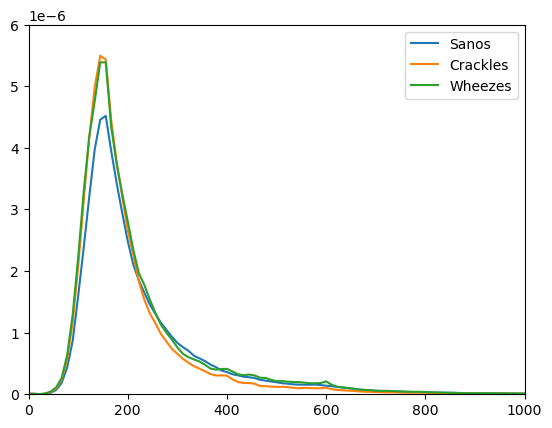

In [9]:
a=s.grafiquelo(promedios,[0,1000],[0,6e-6])

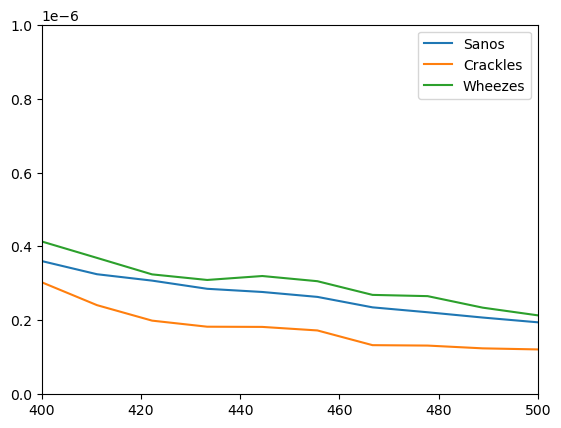

In [10]:
b=s.grafiquelo(promedios,[400,500],[0,1e-6])

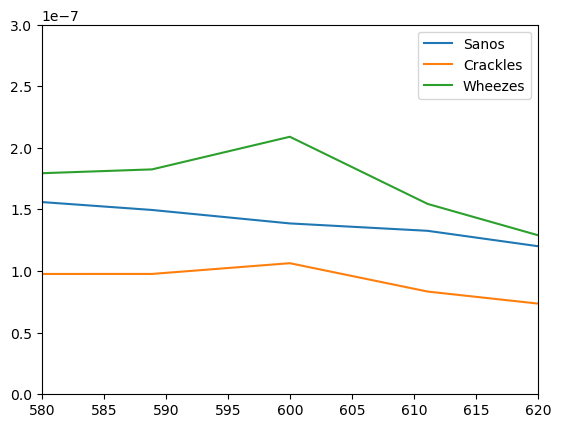

In [11]:
b=s.grafiquelo(promedios,[580,620],[0,3e-7])

In [12]:
df=pd.DataFrame( np.array(promedios))
df.to_csv("promedios.csv",index=False)

In [13]:
#!wget https://raw.githubusercontent.com/Astolfo2332/Biosenales_el_regreso/main/promedios.cvs

In [14]:
prom= np.loadtxt('promedios.csv', delimiter=',')
prom=prom[1:]

## Rangos de comparación para la PSD

- Rango de los 3: 580 a 600 Hz
- Rango de silbancia y sanos-crepitancia 400-500 Hz

In [22]:
guelch=[sano_welch_list, crackles_welch_list,wheezes_welch_list]
listas=[sano_list,crackles_list,wheezes_list]

In [23]:
d=s.el_finalizador(guelch,listas,580,600)

In [24]:
d

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,3.164221e-07,4.350436e-10,0.000003
1,Healthy,2.896482e-07,2.649845e-10,0.000003
2,Healthy,2.522252e-07,2.641582e-10,0.000003
3,Healthy,2.676754e-07,2.213224e-10,0.000003
4,Healthy,2.336660e-07,2.802008e-10,0.000003
...,...,...,...,...
5850,Wheezes,7.166203e-06,1.107375e-08,0.000081
5851,Wheezes,6.482614e-06,8.884726e-09,0.000074
5852,Wheezes,6.472902e-07,6.174641e-10,0.000008
5853,Wheezes,5.825852e-07,4.715493e-10,0.000007


In [25]:
d.to_csv("DataSet_580_600.csv",index=False)

In [26]:
d2=s.el_finalizador(guelch,listas,400,500)

In [27]:
d2

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,3.026024e-07,4.350436e-10,0.000003
1,Healthy,2.794194e-07,2.649845e-10,0.000003
2,Healthy,2.446223e-07,2.641582e-10,0.000003
3,Healthy,2.594380e-07,2.213224e-10,0.000003
4,Healthy,2.261286e-07,2.802008e-10,0.000003
...,...,...,...,...
5850,Wheezes,6.907296e-06,1.107375e-08,0.000081
5851,Wheezes,6.336135e-06,8.884726e-09,0.000074
5852,Wheezes,6.359045e-07,6.174641e-10,0.000008
5853,Wheezes,5.747970e-07,4.715493e-10,0.000007


In [29]:
d2.to_csv("DataSet_400_500.csv",index=False)